In [1]:
using MAT, Plots, LinearAlgebra, Statistics

In [2]:
bloch_dict_file = "bloch_dict_10mm.mat"

f_idx = matopen("D_IDX_SP_Phantom2025.mat")
idx = read(f_idx, "idx")
close(f_idx)

f_dict = matopen("D_Phantom2025_invEff096_SPinf_norefocusingTEadj_576InvTime_1000RF_10mm_101iso_0.mat")
dict_epg = read(f_dict, "dict0")
close(f_dict)

# FULL SET
sampled_pairs_ms = [(row[1], row[2]) for row in eachrow(idx)]
sampled_pairs_s  = [(T1 / 1000, T2 / 1000) for (T1, T2) in sampled_pairs_ms]

# SAMPLE OF 3
# T1T2_pairs = [(row[1], row[2]) for row in eachrow(idx)]
# sampled_pairs_ms = sample(T1T2_pairs, 3; replace=false) 
# sampled_pairs_s  = [(T1 / 1000, T2 / 1000) for (T1, T2) in sampled_pairs_ms]

5865-element Vector{Tuple{Float32, Float32}}:
 (0.1, 0.01)
 (0.12, 0.01)
 (0.14, 0.01)
 (0.16, 0.01)
 (0.18, 0.01)
 (0.2, 0.01)
 (0.22, 0.01)
 (0.24, 0.01)
 (0.26, 0.01)
 (0.28, 0.01)
 ⋮
 (2.2, 1.5)
 (2.3, 1.5)
 (2.4, 1.5)
 (2.5, 1.5)
 (2.6, 1.5)
 (2.7, 1.5)
 (2.8, 1.5)
 (2.9, 1.5)
 (3.0, 1.5)

In [6]:
epg_dict = Dict{Tuple{Int, Int}, Vector{Float64}}()

for (T1, T2) in sampled_pairs_ms
    i = findfirst(j -> idx[j, 1] == T1 && idx[j, 2] == T2, 1:size(idx, 1))

    signal = abs.(dict_epg[:, i])
    signal ./= norm(signal)

    epg_dict[(T1, T2)] = signal
end




bloch_data = matread(bloch_dict_file)
dict0_bloch = bloch_data["dict0"]
idx_bloch = bloch_data["idx"]

bloch_dict = Dict{Tuple{Int, Int}, Vector{Float64}}()
for j in 1:size(idx_bloch, 1)
    key = Tuple(Int.(idx_bloch[j, :]))
    sig = vec(dict0_bloch[:, j])
    bloch_dict[key] = sig ./ norm(sig)
end




shared_keys = intersect(keys(bloch_dict), keys(epg_dict))

errors = Dict{Tuple{Int, Int}, Float64}()

for key in shared_keys
    sig_epg = epg_dict[key]
    sig_bloch = bloch_dict[key]
    err = norm(sig_epg - sig_bloch)
    errors[key] = err
end

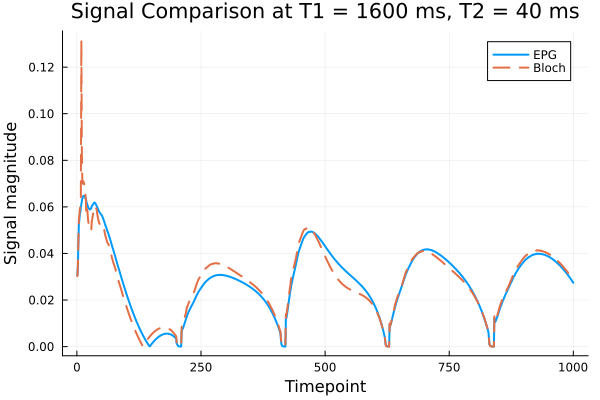

In [7]:
sample_key = first(shared_keys)
plot(abs.(epg_dict[sample_key]), label="EPG", linewidth=2)
plot!(abs.(bloch_dict[sample_key]), label="Bloch", linestyle=:dash, linewidth=2)
title!("Signal Comparison at T1 = $(sample_key[1]) ms, T2 = $(sample_key[2]) ms")
xlabel!("Timepoint")
ylabel!("Signal magnitude")

In [8]:
mean_error = mean(values(errors))
max_error = maximum(values(errors))
@info "Compared $(length(shared_keys)) signals"
@info "Mean L2 error: $mean_error"
@info "Max L2 error: $max_error"

┌ Info: Compared 5865 signals
└ @ Main c:\Users\lucya\MSC_PROJECT\Dictionary\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:3
┌ Info: Mean L2 error: 0.1417283319737545
└ @ Main c:\Users\lucya\MSC_PROJECT\Dictionary\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:4
┌ Info: Max L2 error: 0.4492829434968863
└ @ Main c:\Users\lucya\MSC_PROJECT\Dictionary\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:5


In [9]:
# histogram(collect(values(errors)), bins=50, title="EPG vs Bloch Signal Errors", xlabel="L2 error", ylabel="Count")


In [10]:
# Returns the dictionary key with minimal Euclidean distance to (target_T1, target_T2)
function find_nearest_key(dict::Dict{Tuple{Int, Int}, Vector{Float64}}, target_T1::Real, target_T2::Real)
    keys_list = collect(keys(dict))
    dists = [sqrt((k[1] - target_T1)^2 + (k[2] - target_T2)^2) for k in keys_list]
    nearest_idx = argmin(dists)
    return keys_list[nearest_idx]
end


find_nearest_key (generic function with 1 method)

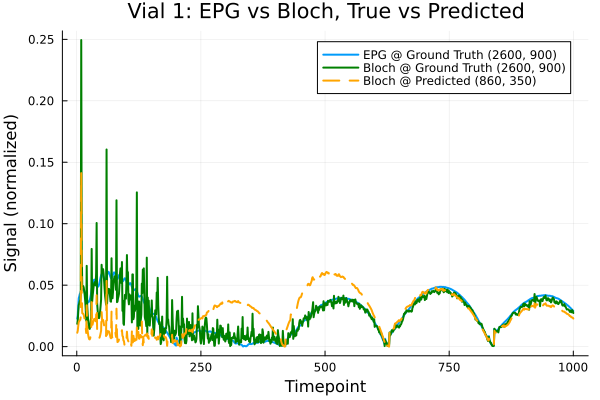

In [11]:
plot()  # starts a new, empty plot (optional)

# === Ground truth and predicted values for Vial 1 ===
true_T1, true_T2 = 2572, 886
pred_T1, pred_T2 = 860, 350

# === Find nearest keys in both dictionaries ===
true_key_epg  = find_nearest_key(epg_dict,  true_T1, true_T2)
pred_key_epg  = find_nearest_key(epg_dict,  pred_T1, pred_T2)
true_key_bloch = find_nearest_key(bloch_dict, true_T1, true_T2)
pred_key_bloch = find_nearest_key(bloch_dict, pred_T1, pred_T2)

# === Extract signals ===
sig_epg_true  = epg_dict[true_key_epg]
sig_epg_pred  = epg_dict[pred_key_epg]
sig_bloch_true = bloch_dict[true_key_bloch]
sig_bloch_pred = bloch_dict[pred_key_bloch]

# === Plot all 4 signals ===
plot(sig_epg_true, label="EPG @ Ground Truth $(true_key_epg)", lw=2)
#plot!(sig_epg_pred, label="EPG @ Predicted $(pred_key_epg)", lw=2, linestyle=:dash)
plot!(sig_bloch_true, label="Bloch @ Ground Truth $(true_key_bloch)", lw=2, color=:green)
plot!(sig_bloch_pred, label="Bloch @ Predicted $(pred_key_bloch)", lw=2, linestyle=:dash, color=:orange)

xlabel!("Timepoint")
ylabel!("Signal (normalized)")
title!("Vial 1: EPG vs Bloch, True vs Predicted")
